<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://cdn-images-1.medium.com/max/716/1*vzFwXFJOrg6WRGNsYYT6qg.png)
_image [source](https://towardsdatascience.com/image-captioning-in-deep-learning-9cd23fb4d8d2)_



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [ ]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/YDS_DL/week6_RNN/handout.tar.gz (Unzipped Files)

/content/drive/MyDrive/YDS_DL/week6_RNN/handout.tar.gz (Unzipped Files)


### Data preprocessing

In [ ]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 195 ms, sys: 654 ms, total: 848 ms
Wall time: 1.79 s


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [ ]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [ ]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [ ]:
# Build a Vocabulary
from collections import Counter
from itertools import chain

word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure

word_counts = Counter(list(chain(*list(chain(*captions)))))

In [ ]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [ ]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [ ]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size) 
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens) 
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, (hn, cn) = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [ ]:
network = CaptionNet(n_tokens)

In [ ]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [ ]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float tensor
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    batch_size, caption_len = captions_ix_next.size()
    

    criterion = nn.CrossEntropyLoss()

    loss = criterion(logits_for_next.view(-1, n_tokens), 
              captions_ix_next.view(-1))

    return loss

In [ ]:
captions_ix = dummy_capt_ix
image_vectors = dummy_img_vec

captions_ix_inp = captions_ix[:, :-1].contiguous()
captions_ix_next = captions_ix[:, 1:].contiguous()

batch_size, caption_len = captions_ix_next.size()

logits_for_next = network.forward(image_vectors, captions_ix_inp)

criterion = nn.CrossEntropyLoss()

loss = criterion(logits_for_next.contiguous().view(-1, n_tokens), 
              captions_ix_next.contiguous().view(-1))
# развернуть captions_ix_next на весь словарик и дело в кармане

In [ ]:
logits_for_next.contiguous().view(-1, n_tokens).size()

torch.Size([75, 10403])

In [ ]:
logits_for_next.view(batch_size*caption_len, -1).size()

torch.Size([75, 10403])

In [ ]:
captions_ix_next.contiguous().view(-1).size()

torch.Size([75])

In [ ]:
captions_ix_next.view(batch_size*caption_len).size()

torch.Size([75])

In [ ]:
loss

tensor(9.2687, grad_fn=<NllLossBackward0>)

In [ ]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [ ]:
opt = torch.optim.Adam(network.parameters())

# Training

* First implement the batch generator
* Than train the network as usual

In [ ]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [ ]:
generate_batch(img_codes,captions,3)

(tensor([[0.2104, 0.3194, 0.1913,  ..., 0.0050, 0.0779, 0.1994],
         [0.1335, 0.3838, 0.9633,  ..., 0.2697, 0.3161, 0.4996],
         [0.0104, 0.1261, 0.2651,  ..., 0.1348, 0.7224, 0.0875]]),
 tensor([[   1,   45,  115,  279,   41,   78,   73,   79,  248,   12,    2,    3,
             3,    3,    3,    3,    3,    3,    3,    3],
         [   1,   24, 4000, 5568,   58,   11,   35,   24,  697,  291,   12,    2,
             3,    3,    3,    3,    3,    3,    3,    3],
         [   1,   57,    6,   47, 2089,   15,  230,  211,  624,  117, 5216,   45,
           541,  578,   58,  543,    6,  179,   12,    2]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [ ]:
batch_size = 50  # adjust me
n_epochs = 20 # adjust me
n_batches_per_epoch = 100  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [ ]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        opt.zero_grad()
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        loss_t.backward()
        opt.step()
        
        train_loss += loss_t.detach().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.detach().numpy()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 100/100 [00:34<00:00,  2.93it/s]



Epoch: 0, train loss: 2.2263977551460266, val loss: 2.0760852575302122


100%|██████████| 100/100 [00:34<00:00,  2.89it/s]



Epoch: 1, train loss: 2.0785971903800964, val loss: 1.9508374691009522


100%|██████████| 100/100 [00:31<00:00,  3.15it/s]



Epoch: 2, train loss: 2.1162565410137177, val loss: 1.6822771787643434


100%|██████████| 100/100 [00:32<00:00,  3.03it/s]



Epoch: 3, train loss: 2.00610364317894, val loss: 2.0952396631240844


100%|██████████| 100/100 [00:33<00:00,  2.94it/s]



Epoch: 4, train loss: 1.9618593096733092, val loss: 1.7726315021514893


100%|██████████| 100/100 [00:33<00:00,  2.99it/s]



Epoch: 5, train loss: 1.925289357304573, val loss: 2.0684387922286986


100%|██████████| 100/100 [00:35<00:00,  2.84it/s]



Epoch: 6, train loss: 1.812984163761139, val loss: 1.7248912811279298


100%|██████████| 100/100 [00:34<00:00,  2.91it/s]



Epoch: 7, train loss: 1.8676763916015624, val loss: 1.9208633422851562


100%|██████████| 100/100 [00:34<00:00,  2.89it/s]



Epoch: 8, train loss: 1.7848427373170852, val loss: 1.783773374557495


100%|██████████| 100/100 [00:34<00:00,  2.91it/s]



Epoch: 9, train loss: 1.8051041567325592, val loss: 1.8566444635391235


100%|██████████| 100/100 [00:33<00:00,  2.95it/s]



Epoch: 10, train loss: 1.8097853982448577, val loss: 1.8764281511306762


100%|██████████| 100/100 [00:34<00:00,  2.90it/s]



Epoch: 11, train loss: 1.7606355035305024, val loss: 1.8300668954849244


100%|██████████| 100/100 [00:33<00:00,  3.01it/s]



Epoch: 12, train loss: 1.7755702674388885, val loss: 1.511586320400238


100%|██████████| 100/100 [00:34<00:00,  2.88it/s]



Epoch: 13, train loss: 1.7469582372903825, val loss: 1.7563129901885985


100%|██████████| 100/100 [00:35<00:00,  2.85it/s]



Epoch: 14, train loss: 1.7562680554389953, val loss: 1.6220694780349731


100%|██████████| 100/100 [00:33<00:00,  2.97it/s]



Epoch: 15, train loss: 1.7495642161369325, val loss: 1.8020841598510742


100%|██████████| 100/100 [00:34<00:00,  2.86it/s]



Epoch: 16, train loss: 1.7128003615140914, val loss: 1.6815765857696534


100%|██████████| 100/100 [00:34<00:00,  2.88it/s]



Epoch: 17, train loss: 1.694681442975998, val loss: 1.5837094068527222


100%|██████████| 100/100 [00:34<00:00,  2.88it/s]



Epoch: 18, train loss: 1.73172201693058, val loss: 1.5957735657691956


100%|██████████| 100/100 [00:35<00:00,  2.78it/s]



Epoch: 19, train loss: 1.6715084618330003, val loss: 1.677860975265503
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.inception import Inception3
from warnings import warn

class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    
from torch.utils.model_zoo import load_url
def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model


In [ ]:
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:47: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [ ]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [ ]:
!pip install scipy==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2022-08-11 13:22:13--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2022-08-11 13:22:13--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.004s  

2022-08-11 13:22:13 (12.9 MB/s) - ‘data/img.jpg’ sa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  


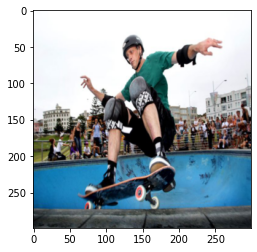

In [ ]:
plt.imshow(img)

In [ ]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard in the air .
a man riding a skateboard on a skateboard .
a man is riding a skateboard on a skateboard .
a man is riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard
a man is riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .


--2022-08-11 13:22:25--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 162.159.135.42
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2022-08-11 13:22:26--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K   272KB/s    in 0.4s    

2022-08-11 13:22:27 (272 KB/s) - ‘data/img.jpg’ saved [106870/106870]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


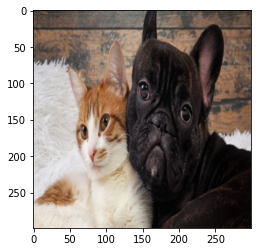

a cat is sitting on a bed with a teddy bear .
a cat is laying on a bed with a dog .
a cat sitting on a bed with a dog .
a cat is laying on a bed with a dog .
a cat is laying on a bed with a dog .
a cat laying on a bed with a dog on it .
a cat sitting on a bed with a remote control .
a cat is laying on a bed with a stuffed animal .
a cat is sitting on a bed with a dog .
a cat is sitting on a bed with a cat .


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  


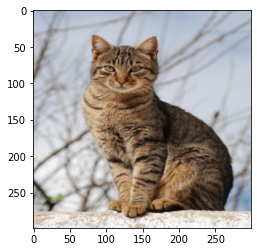

a cat sitting on a bed with a cat .
a cat laying on a bed with a dog .
a cat sitting on a bed with a cat .
a cat sitting on a bed with a cat .
a cat laying on a bed with a cat .
a cat laying on a bed with a dog .
a cat laying on a bed with a cat .
a cat laying on a bed with a cat .
a cat sitting on a bed with a dog .
a cat laying on a bed with a dog .


In [ ]:
img = plt.imread('/content/Cat_November_2010-1a.jpg.webp')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [ ]:
#apply your network on image sample you found
#
#

In [ ]:
img = plt.imread('/content/photo_2022-07-17_14-20-05.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  


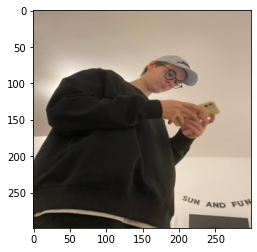

a man wearing a helmet and a tie .
a man wearing a hat and a tie in a black shirt .
a man with a hat and a tie on a skateboard .
a man wearing a hat and a tie .
a man is holding a cell phone while wearing a hat .
a man with a hat and a tie in a suit .
a man wearing a hat and a tie with a hat and a hat .
a man wearing a hat is holding a cell phone .
a man in a suit and a tie with a hat .
a man holding a cell phone while standing on a skateboard .


In [ ]:
img = plt.imread('/content/photo_2022-08-09_23-43-08.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563